TIme Series Forecast with NHiTS on the Vierlinden dataset (all sensors, 2021)

In [1]:
import sys
sys.path.append('./pytorch-forecasting/')
import pandas as pd
import torch
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, TQDMProgressBar,StochasticWeightAveraging
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_forecasting import Baseline, NHiTS, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import QuantileLoss, MAE, RMSE

### Load data

Split in train and validation

In [2]:
# Read the dataset into a DataFrame
data = pd.read_csv('./RIWWER/Vierlinden/Vierlinden_2021_All.csv')

# Drop columns that have lots of missing values
data.drop(["FLP_Hohenstand_Pumpensumpf_pval","FLP_Strom_P3_pval","FLP_Strom_P4_pval","FLP_Strom_P5_pval","Durchfluss SWP1 und SWP2_pval","FLP_Hohenstand_Becken1_pval","FLP_Hohenstand_Becken3_pval","FLP_Hohenstand_Beckne2_pval"], axis=1, inplace=True)

# NaNs are not allowed by the model
#data.fillna(0.0, inplace=True)
data.fillna(method="bfill", inplace=True)
data.fillna(method="ffill", inplace=True)

# Rescale all columns (Min-Max)
# Note: Scaling is handled in TimeSeriesDataset (see below)
# df = data.drop('Datetime', axis=1)
# df = (df-df.min())/(df.max()-df.min())
# data = pd.concat((data.Datetime, df), axis=1)

# Set Datetime as index
data['Datetime'] = pd.to_datetime(data['Datetime'])

In [3]:
# One time series for every month?
#data['series'] = data['Datetime'].dt.year*12 + data['Datetime'].dt.month
#data['series'] -= data['series'].min()

# One time series for every 5 days?
#data['series'] = pd.Series([h for h in range(73) for _ in range(24*5)])

# One time series for the whole year?
data['series'] = 0

# As many timesteps per timeseries as hours in every month?
time_idx = []
for i in range(1):
    timesteps = len( data[ data['series'] == i ] )
    time_idx += list(range(timesteps))
data['time_idx'] = time_idx
data

,Datetime,Schieber Position_pval,Oberwasser_pval,Unterwasser_pval,Durchflumenge_pval,Berechnete Durchflussmenge_pval,Fllstand SWS_pval,Fllstand RWS_pval,Strom P1_pval,Strom P2_pval,...,Strom Pumpe 2_pval1,Strom Pumpe 3_pval,Niederschlag,Füllstand_RRB,Entleerung_RüB,Füllstand_RüB_1,Füllstand_RüB_2,Füllstand_RüB_3,series,time_idx
0,2021-01-01 00:00:00,100.0,8.140845,5.753623,7.689189,7.732558,75.717949,36.0,1.076923,0.0,...,0.0,1.0,0.000000,1.47,0.098,3.16,3.08,2.72,0,0
1,2021-01-01 01:00:00,100.0,8.000000,5.173913,6.808219,8.271739,75.717949,36.0,1.076923,0.0,...,0.0,1.0,1.182353,1.47,0.099,3.16,3.08,2.72,0,1
2,2021-01-01 02:00:00,100.0,7.967742,5.000000,5.813333,7.197674,75.717949,36.0,1.076923,0.0,...,0.0,1.0,1.182353,1.47,0.096,3.16,3.08,2.72,0,2
3,2021-01-01 03:00:00,100.0,7.076923,4.843750,4.216216,4.743243,75.717949,36.0,1.076923,0.0,...,0.0,1.0,1.182353,1.47,0.098,3.16,3.08,2.72,0,3
4,2021-01-01 04:00:00,100.0,8.464789,5.466667,8.384615,8.325000,75.717949,36.0,1.076923,0.0,...,0.0,1.0,1.182353,1.47,0.098,3.16,3.08,2.72,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2021-12-31 19:00:00,99.0,9.859155,6.147541,9.347222,12.800000,75.033333,35.0,1.700000,0.0,...,0.0,1.0,0.000000,1.06,0.181,1.15,1.29,0.62,0,8755
8756,2021-12-31 20:00:00,99.0,9.111111,5.823529,7.970588,11.211268,76.000000,35.0,1.300000,0.0,...,0.0,1.0,0.000000,1.06,0.179,1.15,1.29,0.62,0,8756
8757,2021-12-31 21:00:00,99.0,11.652778,7.544118,16.804878,17.802326,74.250000,35.0,1.600000,0.0,...,0.0,1.0,0.000000,1.06,0.183,1.15,1.29,0.62,0,8757
8758,2021-12-31 22:00:00,99.0,8.338028,5.287671,7.107692,9.878788,76.200000,35.0,1.233333,0.0,...,0.0,1.0,0.000000,1.06,0.186,1.15,1.29,0.62,0,8758


In [4]:
# Create dataloaders
max_encoder_length = 24*2
max_prediction_length = 5*2
#training_cutoff = data["time_idx"].max() - max_prediction_length #20*max_prediction_length
training_cutoff = data["time_idx"].max() * 4 // 5 # 80% for training
# Note: if you just subtract 1*max_prediction_length, some of the time series (for some of the months) will not be computed

context_length = max_encoder_length
prediction_length = max_prediction_length

# Note: NBeats can only handle one target
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    #scalers={}, # each real variable stored under time_varying..._reals is scaled as default with sklearn.StandardScaler
    target_normalizer="auto",
    time_idx="time_idx",
    target="Entleerung_RüB",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    time_varying_unknown_reals=list(set(data.columns) - {'Datetime', 'series', 'time_idx'}),
    #time_varying_known_reals=list(set(data.columns) - {'Datetime', 'series', 'time_idx', 'Entleerung_RüB'}),
    max_encoder_length=context_length,
    min_encoder_length=max_encoder_length,
    max_prediction_length=prediction_length,
    min_prediction_length=max_prediction_length,
    allow_missing_timesteps=True
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 32
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=18)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=18)

### Baseline

In [6]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to(torch.device('cuda:0'))
predictions = Baseline().predict(val_dataloader)

err = actuals - predictions
mae = err.abs().mean()
print('MAE = ' + str(mae))
rmse = torch.sqrt( torch.square(err).mean() )
print('RMSE = ' + str(rmse))

/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer_new/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer_new/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


MAE = tensor(1.7076, device='cuda:0')
RMSE = tensor(10.2045, device='cuda:0')


### Training

In [5]:
pl.seed_everything(42)
trainer = pl.Trainer(accelerator="gpu",
                     devices = 1,
                     max_epochs = 20,
                     gradient_clip_val=0.01,
                     logger = False)
net = NHiTS.from_dataset(training,
                         learning_rate=3e-2, weight_decay=1e-2,
                         loss=QuantileLoss())
                         #backcast_loss_ratio=1.0)
# Note: 'widths' denotes the width of each forecasting block. By default, the first forecasts the trend, while the second forecasts seasonality.
# Note: comment out backcast_loss_ratio when using QuantileLoss()

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer_new/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer_new/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 3.981071705534973e-05
Restoring states from the checkpoint path at /mnt/KInsektDaten/teo/.lr_find_689ab4e8-9590-493e-a8d6-93e9b3cc1c66.ckpt
Restored all states from the checkpoint at /mnt/KInsektDaten/teo/.lr_find_689ab4e8-9590-493e-a8d6-93e9b3cc1c66.ckpt


suggested learning rate: 3.981071705534973e-05


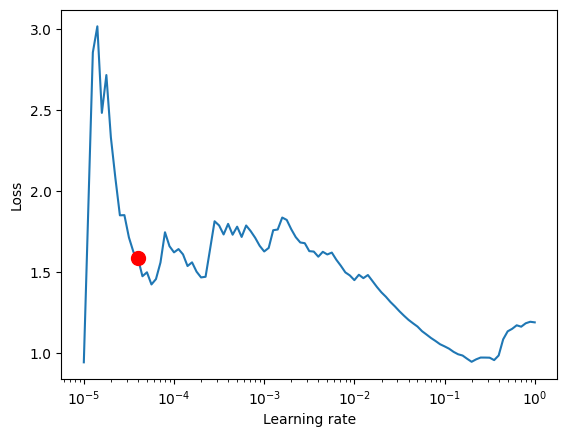

In [6]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(net,
                             train_dataloaders=train_dataloader,
                             val_dataloaders=val_dataloader,
                             min_lr=1e-5)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

Fit model

In [7]:
pl.seed_everything(42)
early_stop = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=True, mode="min")
lr_sched = StochasticWeightAveraging(swa_lrs=res.suggestion(), swa_epoch_start=5, device=torch.device('cuda:0'))
lr_logger = LearningRateMonitor(logging_interval='step')  # log the learning rate ('step' or 'epoch')
logger = TensorBoardLogger("./RIWWER/torch_forecasting/model_checkpoints/NHits_Vierlinden_QL")  # logging results to a tensorboard
# at this path, a folder with the name lightning_logs is searched for; if not found, it is created

trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.01,
    callbacks=[early_stop, lr_logger, TQDMProgressBar(), lr_sched],
    limit_train_batches=150,
    log_every_n_steps=5,
    logger=logger
)

net = NHiTS.from_dataset(
    training,
    learning_rate=res.suggestion(),
    loss=QuantileLoss(),
    dropout=0.1,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    #backcast_loss_ratio=1.0,
)

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    ckpt_path="./RIWWER/torch_forecasting/model_checkpoints/NHits_Vierlinden_QL/lightning_logs/version_2/checkpoints/epoch=99-step=15000.ckpt"
)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer_new/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/tchiaburu/anaconda3/envs/torch_gpu_riwwer_new/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:196: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
Restoring states from the checkpoint path at ./RIWWER/torch_forecasting/model_checkpoints/NHits_Vierlinden_QL/lightning_logs/version_2/checkpo

Sanity Checking: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


## NHits with MASE

### Evaluation

In [8]:
trainer.callback_metrics

{'train_loss': tensor(2.4463),
 'train_loss_step': tensor(1.7786),
 'train_backcast_loss': tensor(0.1339),
 'train_backcast_loss_step': tensor(0.1719),
 'train_forecast_loss': tensor(2.4463),
 'train_forecast_loss_step': tensor(1.7786),
 'val_backcast_loss': tensor(0.1089),
 'val_forecast_loss': tensor(2.3930),
 'val_loss': tensor(2.3930),
 'val_SMAPE': tensor(0.4386),
 'val_MAE': tensor(1.4225),
 'val_RMSE': tensor(3.2073),
 'val_MAPE': tensor(837476.1250),
 'val_MASE': tensor(2.3930),
 'train_loss_epoch': tensor(2.4463),
 'train_backcast_loss_epoch': tensor(0.1339),
 'train_forecast_loss_epoch': tensor(2.4463)}

In [9]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_model = NHiTS.load_from_checkpoint(best_model_path)

./RIWWER/torch_forecasting/model_checkpoints/NHits_Vierlinden/lightning_logs/version_0/checkpoints/epoch=14-step=2250.ckpt


In [10]:
#best_model = NHiTS.load_from_checkpoint(...)

In [11]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to(torch.device('cuda:0')) # actuals were on CPU per default
predictions = best_model.predict(val_dataloader,
                                 trainer_kwargs=dict(default_root_dir="./RIWWER/torch_forecasting/model_checkpoints/NHits_Vierlinden"))
(actuals - predictions).abs().mean()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(1.4225, device='cuda:0')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


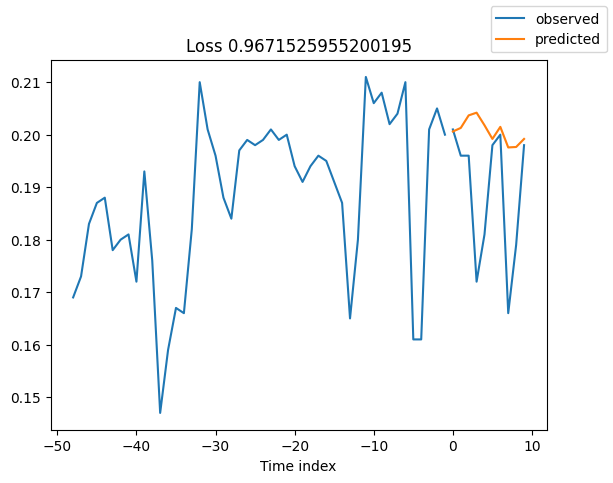

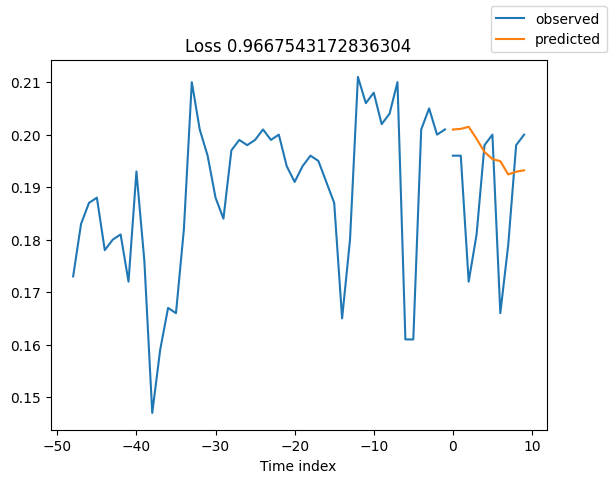

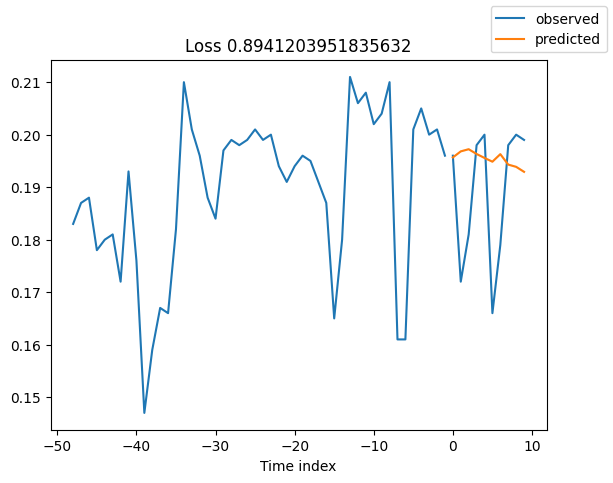

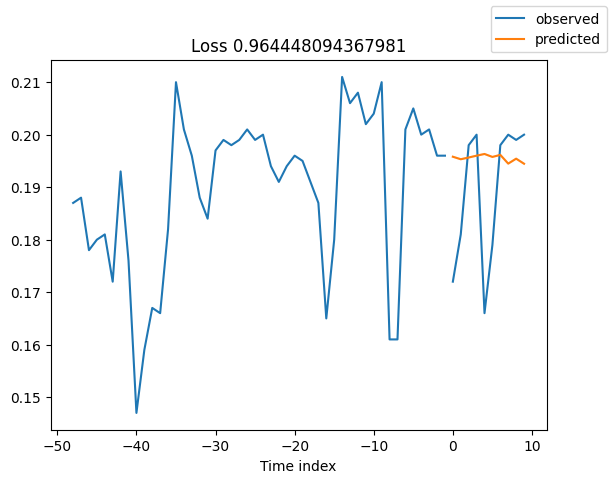

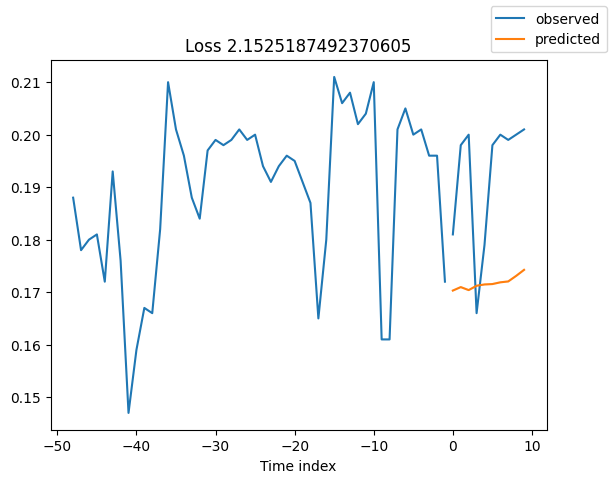

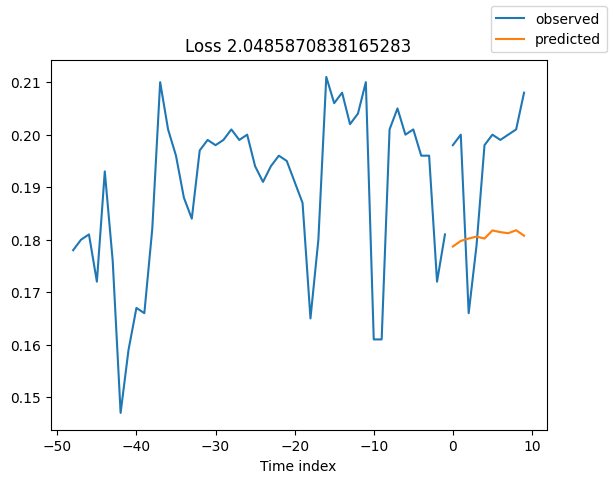

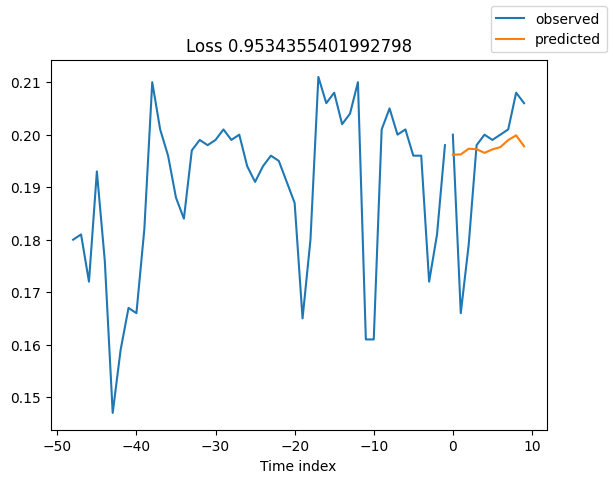

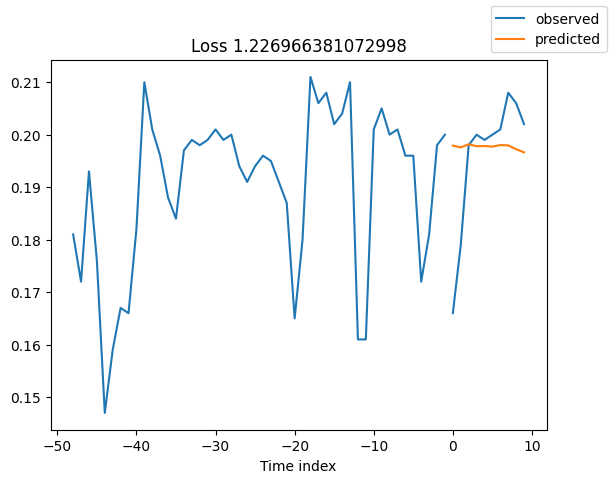

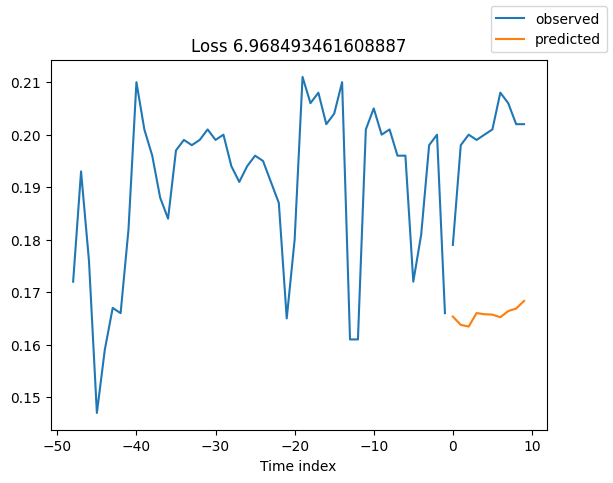

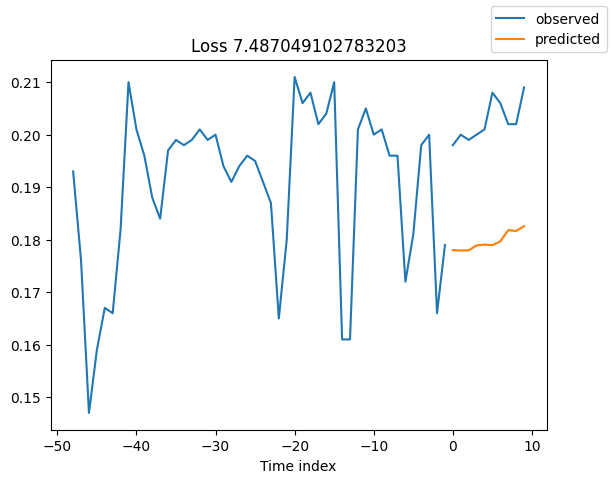

In [12]:
# Some random samples from the val. set
raw_predictions = best_model.predict(val_dataloader, mode="raw",
                                     return_x=True,
                                     trainer_kwargs=dict(default_root_dir="./RIWWER/torch_forecasting/model_checkpoints/NHits_Vierlinden"))
for idx in range(10):
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output,
                               idx=idx, add_loss_to_title=True)

### Interpretation

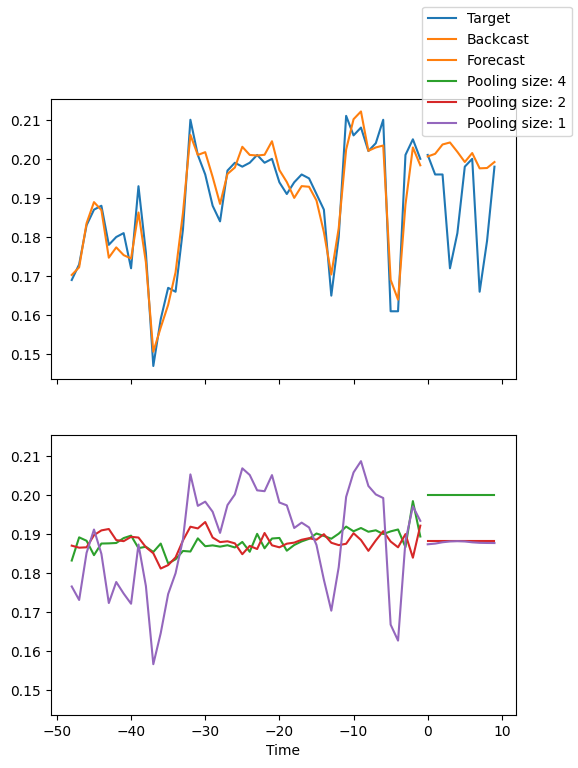

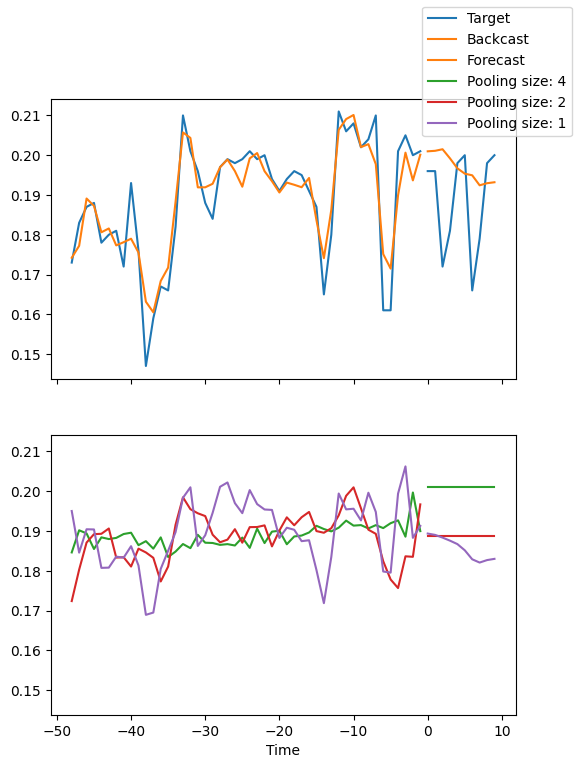

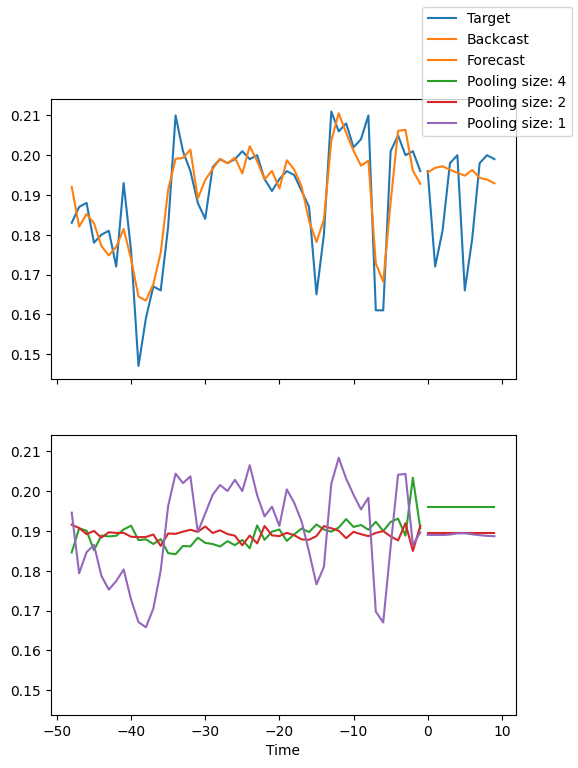

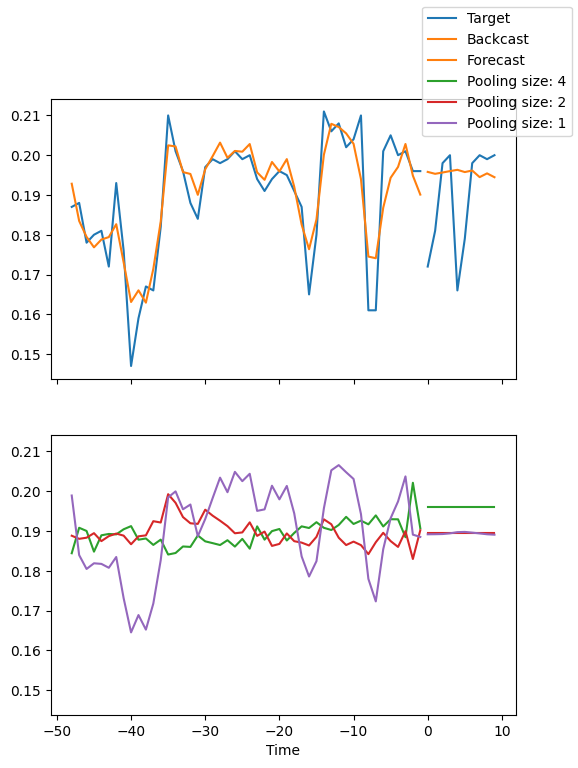

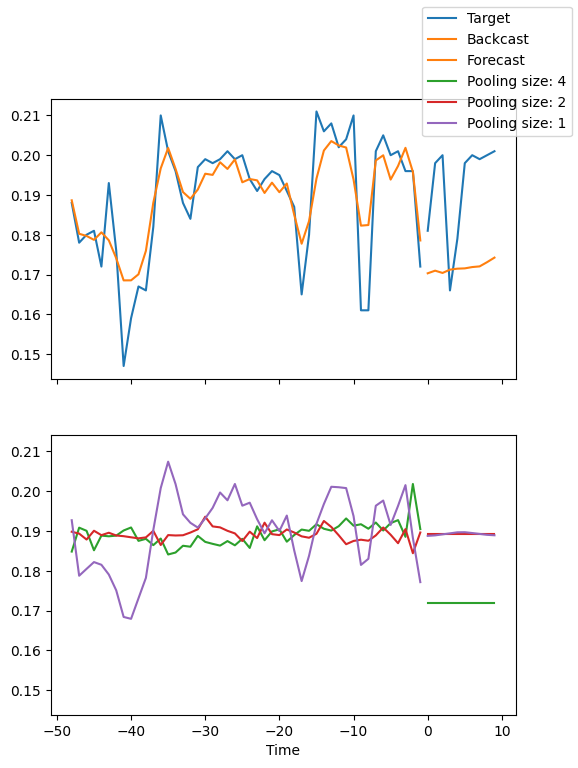

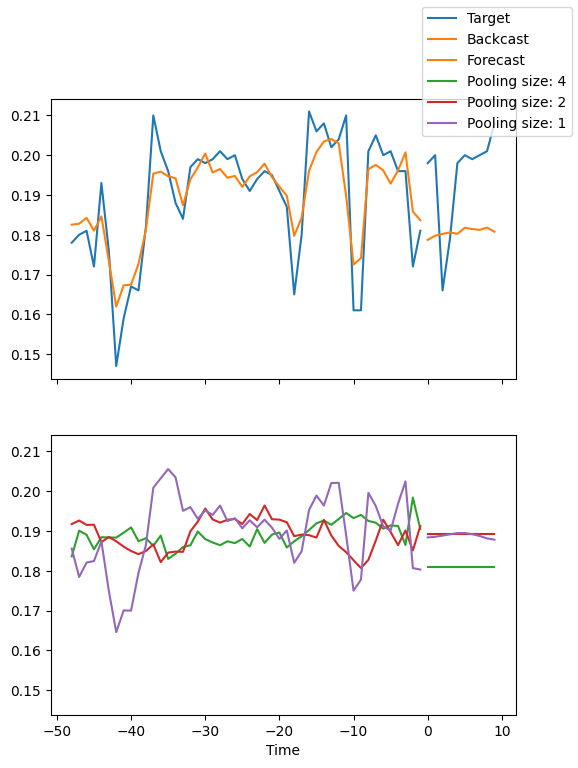

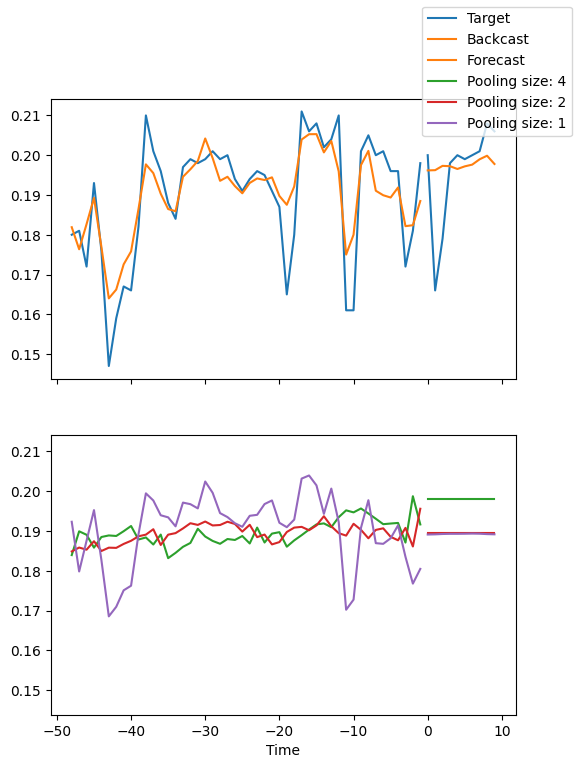

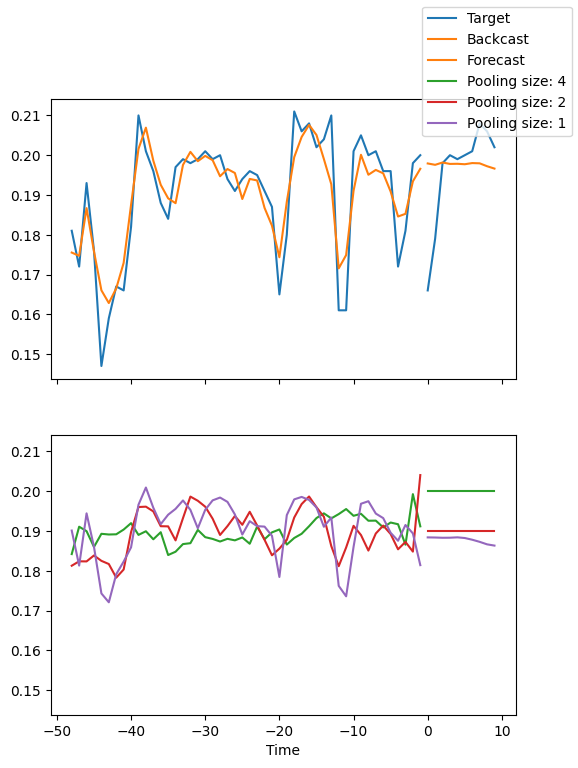

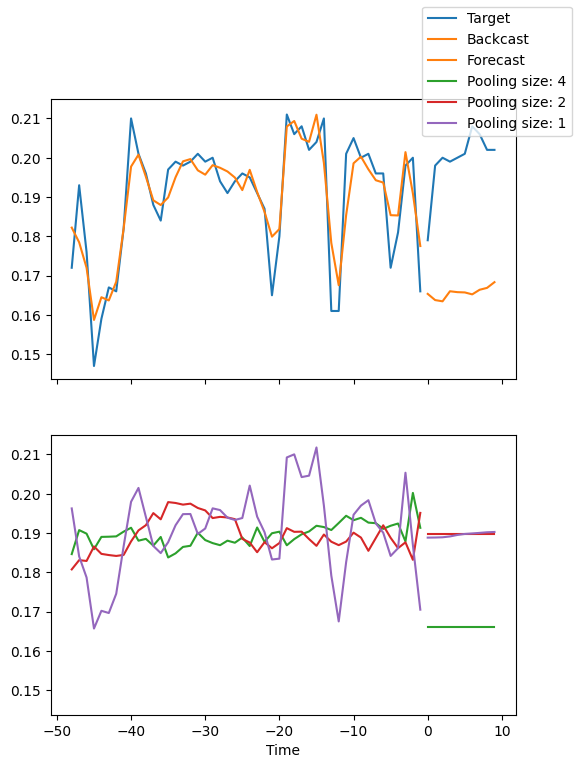

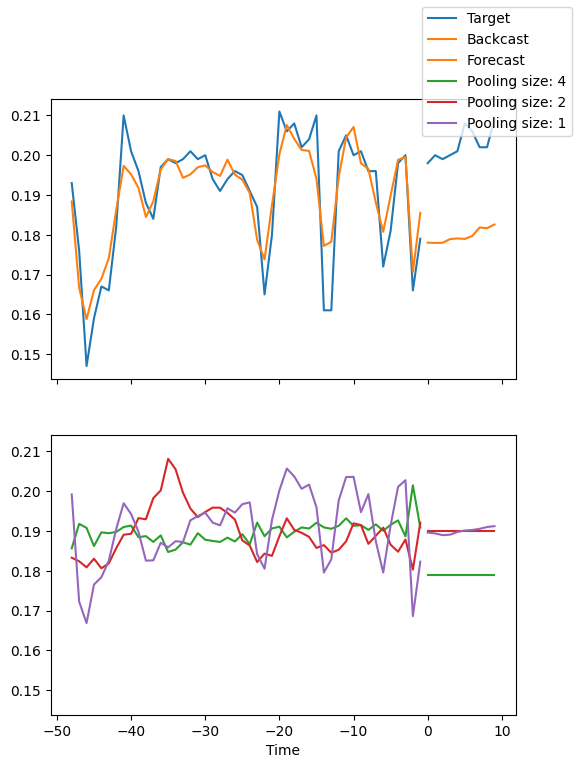

In [13]:
for idx in range(10):
    best_model.plot_interpretation(raw_predictions.x,
                                   raw_predictions.output,
                                   idx=idx)

## NHits with QLoss

### Evaluation

In [14]:
trainer.callback_metrics

{}

In [9]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_model = NHiTS.load_from_checkpoint(best_model_path)

./RIWWER/torch_forecasting/model_checkpoints/NHits_Vierlinden_QL/lightning_logs/version_2/checkpoints/epoch=99-step=15000.ckpt


In [10]:
#best_model = NHiTS.load_from_checkpoint(...)

In [11]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)]).to(torch.device('cuda:0')) # actuals were on CPU per default
predictions = best_model.predict(val_dataloader,
                                 trainer_kwargs=dict(default_root_dir="./RIWWER/torch_forecasting/model_checkpoints/NHits_Vierlinden_QL"))
(actuals - predictions).abs().mean()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(1.7085, device='cuda:0')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


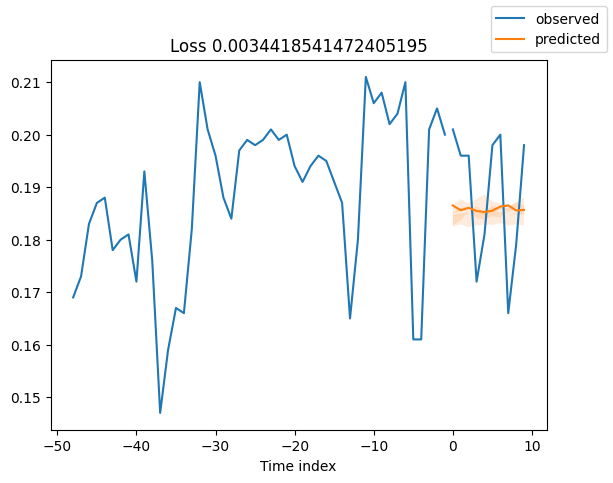

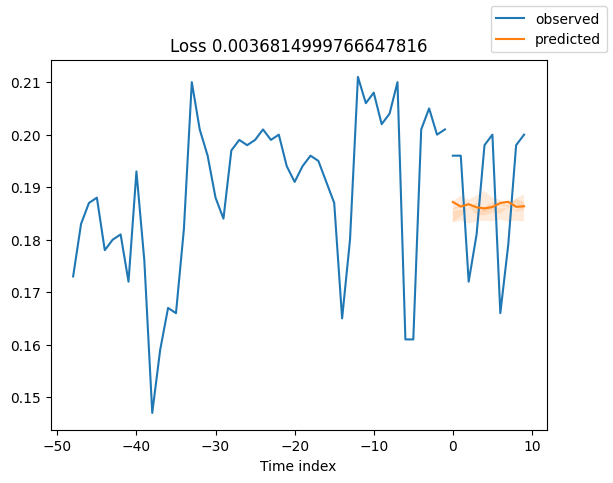

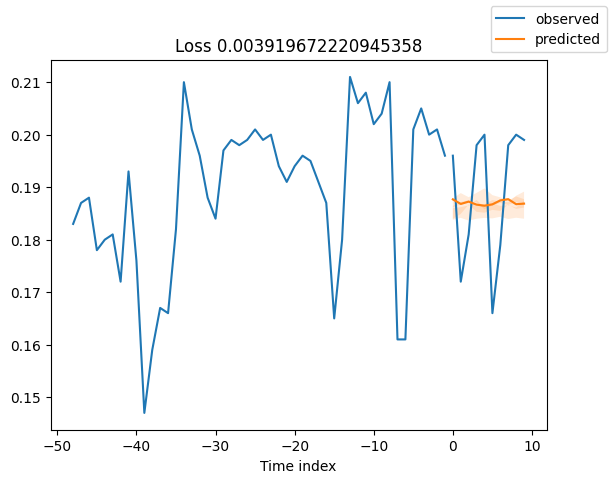

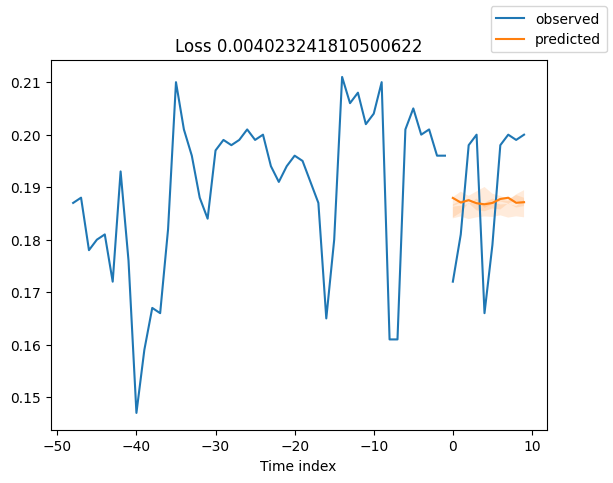

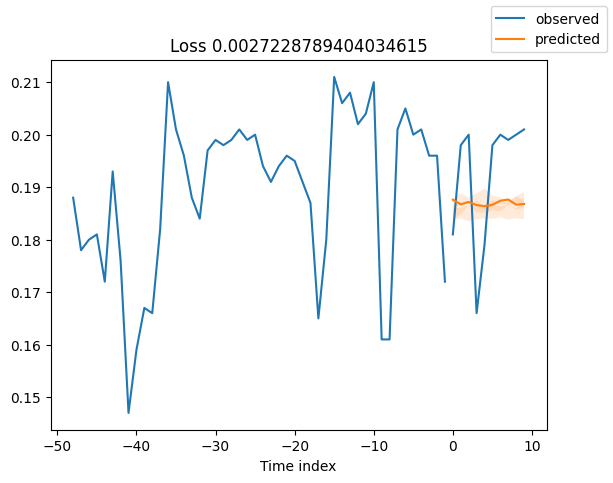

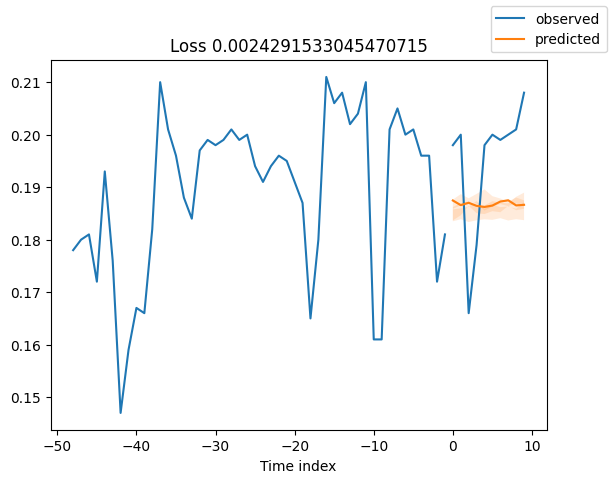

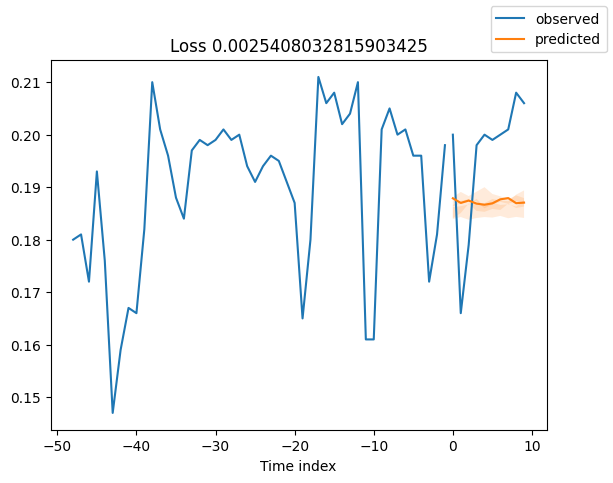

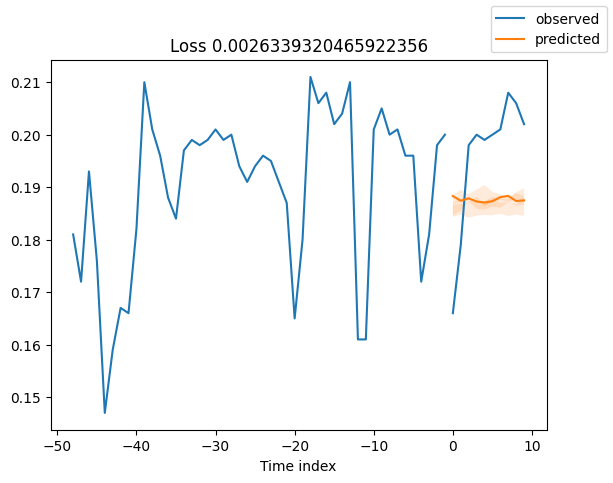

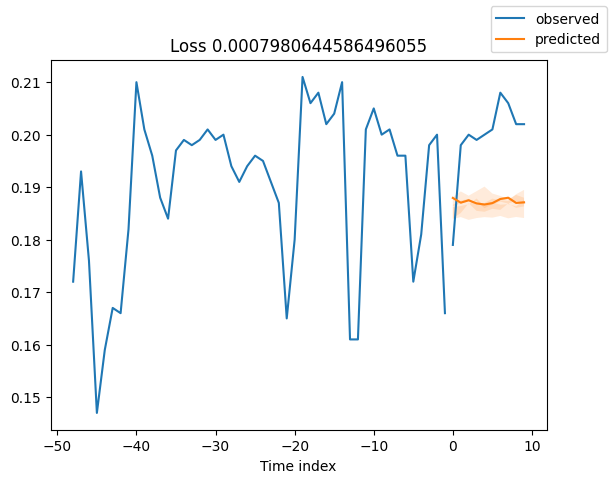

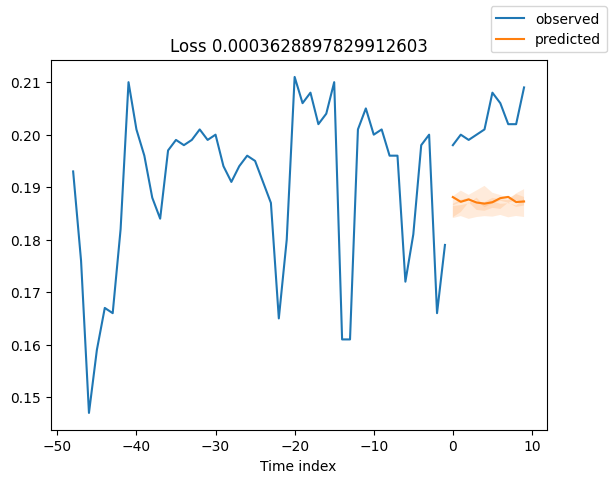

In [12]:
# Some random samples from the val. set
raw_predictions = best_model.predict(val_dataloader, mode="raw",
                                     return_x=True,
                                     trainer_kwargs=dict(default_root_dir="./RIWWER/torch_forecasting/model_checkpoints/NHits_Vierlinden_QL"))
for idx in range(10):
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output,
                               idx=idx, add_loss_to_title=True)

### Interpretation

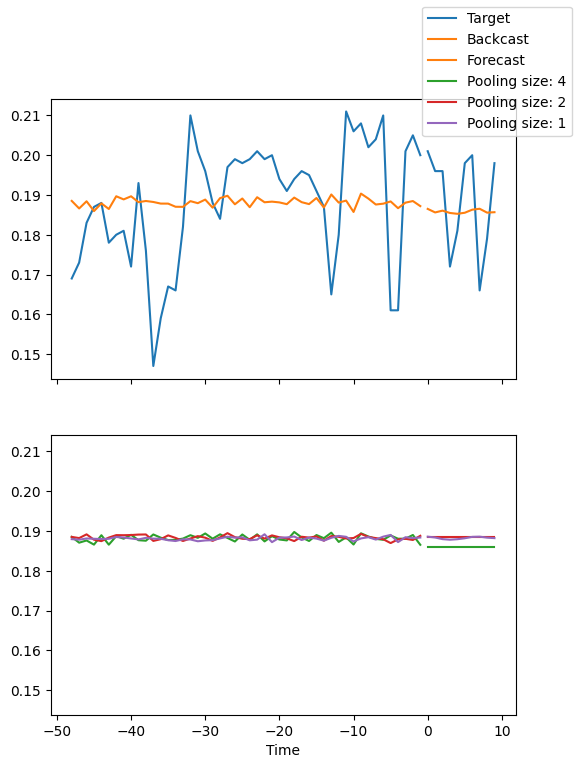

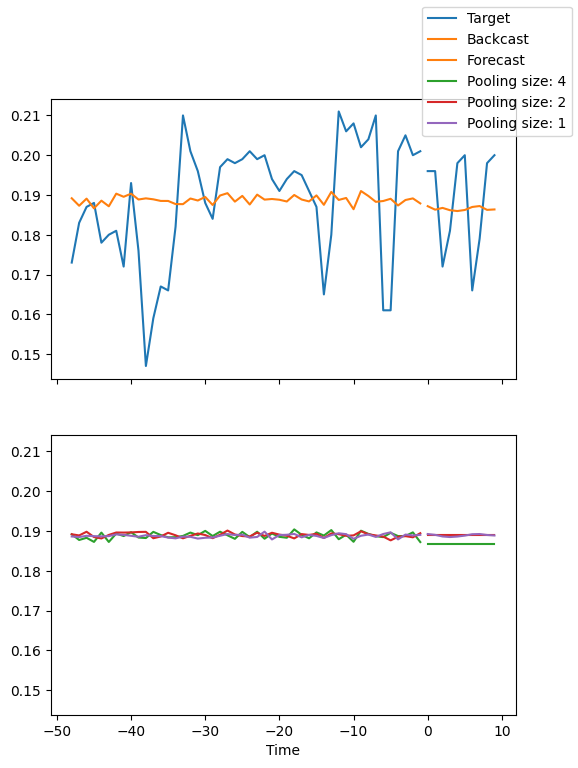

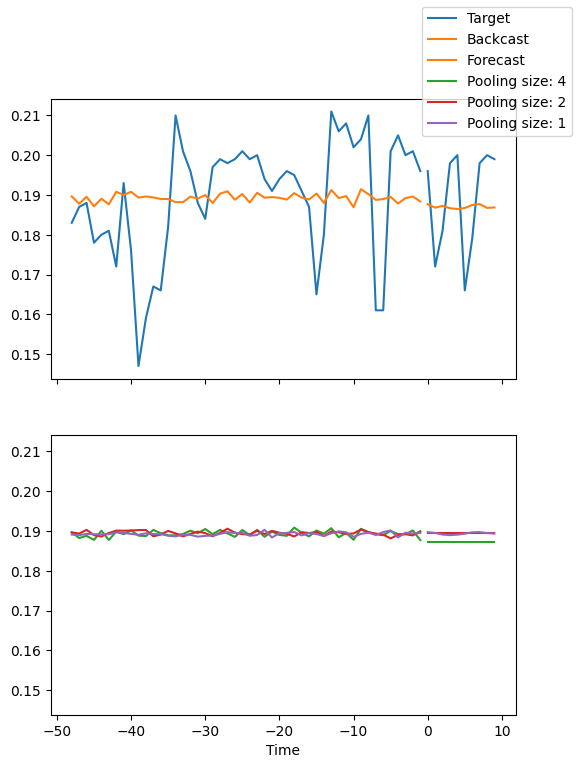

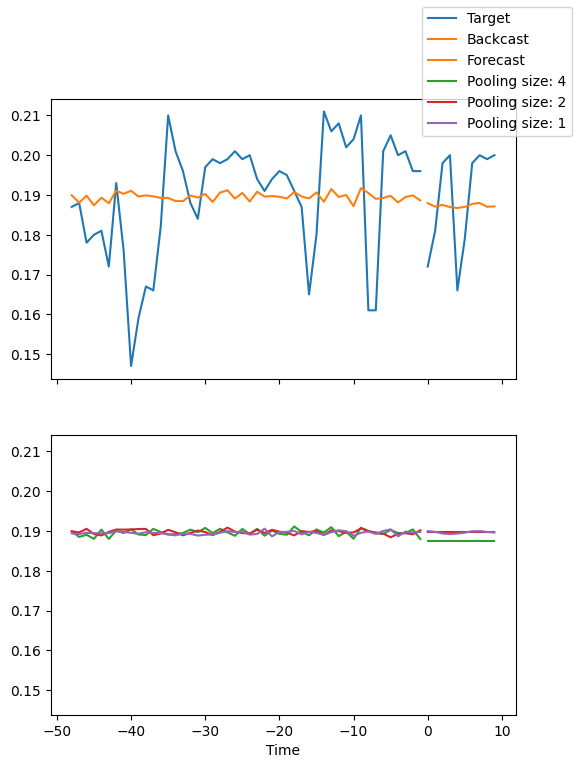

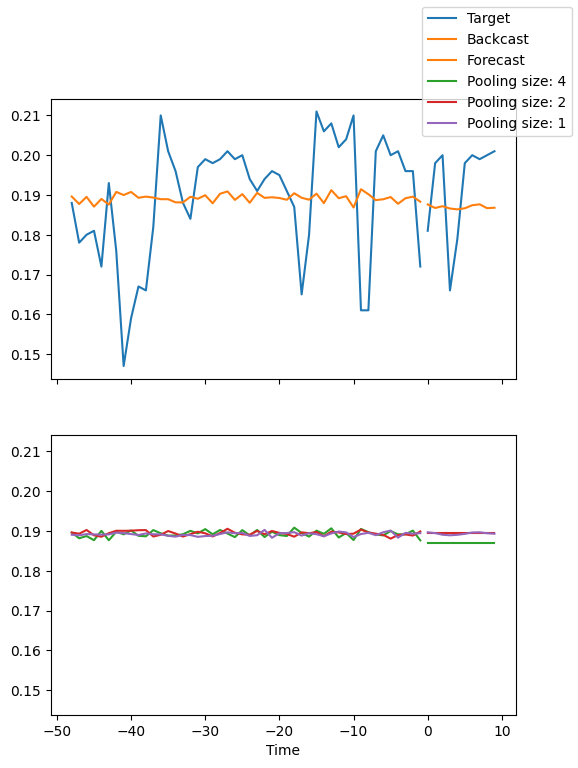

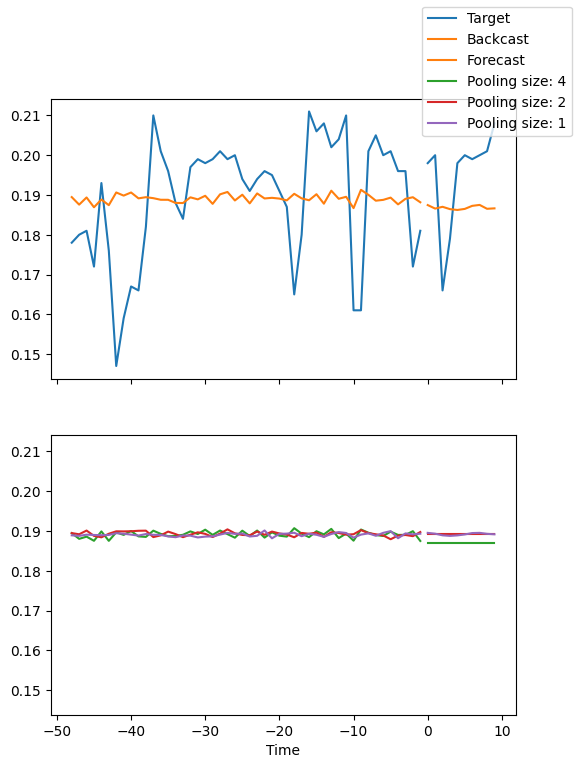

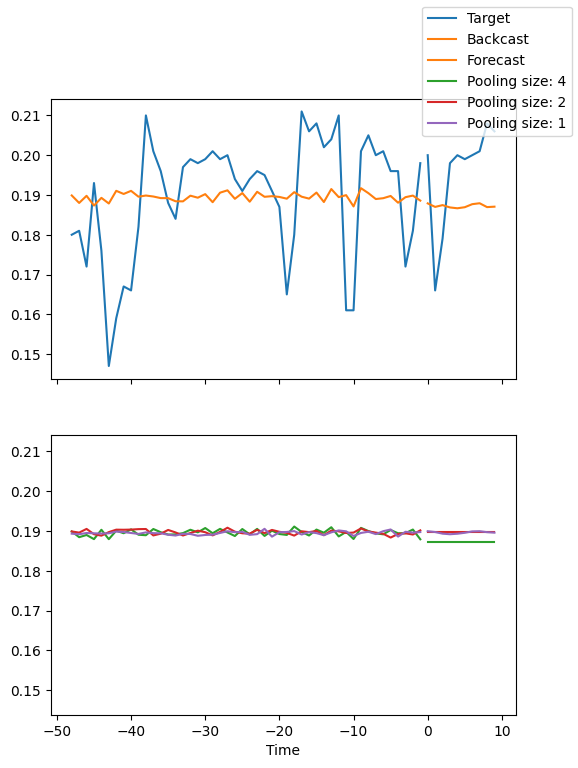

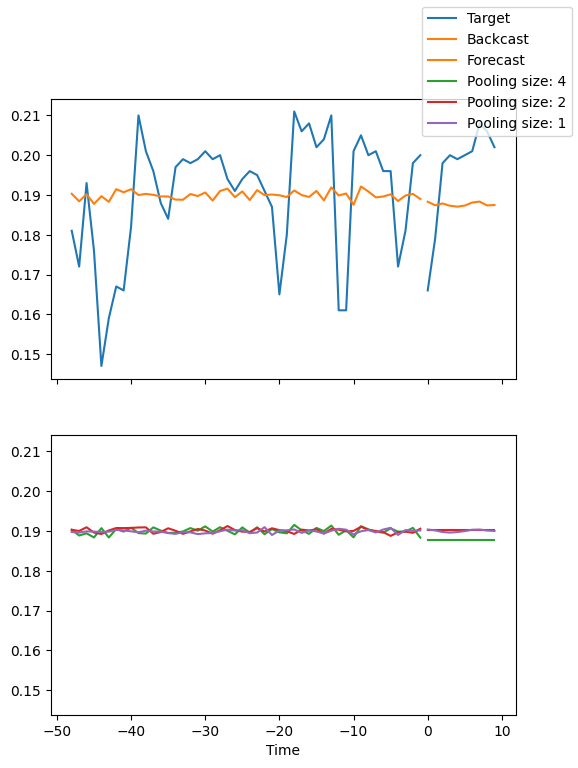

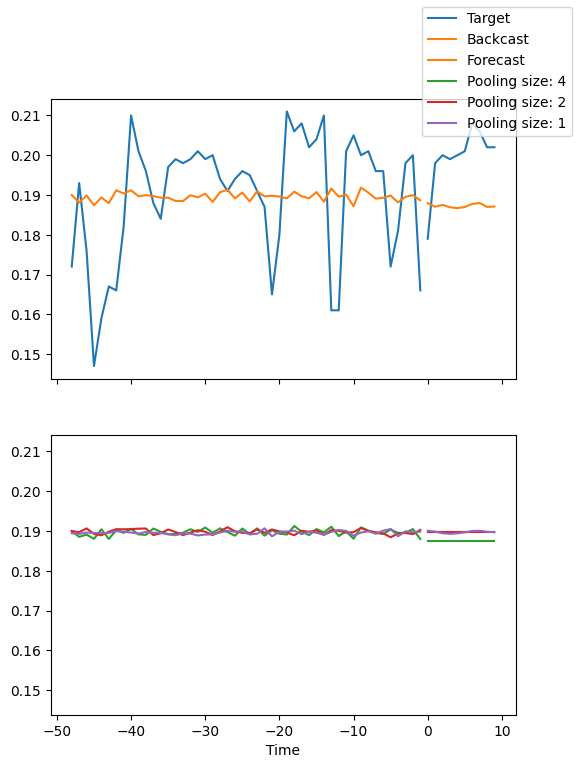

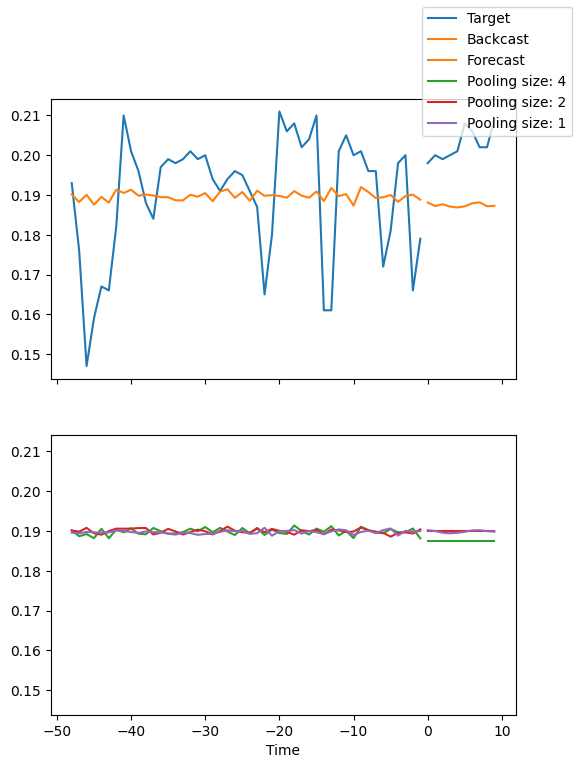

In [13]:
for idx in range(10):
    best_model.plot_interpretation(raw_predictions.x,
                                   raw_predictions.output,
                                   idx=idx)